In [ ]:
import os
import numpy as np
import requests
from PIL import Image, ImageDraw
import torch
from torch.utils.data import DataLoader, Dataset

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms import ToTensor
from torchvision.transforms.v2 import functional as F
from transformers import OwlViTProcessor, OwlViTForObjectDetection

In [ ]:
class PennFudanDataset(Dataset):
    def __init__(self, root, image_processor):
        self.root = root
        self.annots_path = "PennFudanPed/Annotation"
        self.annots_list = os.listdir(os.path.join(self.root, self.annots_path))
        self.image_processor = image_processor

    def getimgPath(self, t):
        return t[1].split(' : ')[-1][1:-1]

    def getBBoxs(self, t, img_shape):
        ts = [x for x in t if 'Bounding box for object' in x]
        bboxes = []
        for tss in ts:
            ts1 = tss.split(' : ')[-1]
            bbox = []
            for tss1 in ts1.split(' - '):
                tss2 = tss1[1:-1].split(', ')
                bbox.append(float(tss2[0])/img_shape[0])
                bbox.append(float(tss2[1])/img_shape[1])
            bboxes.append(bbox)
        return np.array(bboxes)

    def __getitem__(self, idx):
        annot_path = os.path.join(self.root, self.annots_path, self.annots_list[idx])
        annot_info = open(annot_path).read().split('\n')
        imgPath = self.getimgPath(annot_info)

        img_path = os.path.join(self.root, imgPath)
        img = Image.open(img_path)
        boxes = self.getBBoxs(annot_info, img.size)
        num_objs = len(boxes)

        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        img = ToTensor()(img.resize((768, 768)))

        target = {}
        target["boxes"] = torch.Tensor(boxes)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        target['img_path'] = img_path

        img_pixels = image = self.image_processor(images=img, return_tensors="pt")["pixel_values"].squeeze(0)

        return img, target['labels'], target['boxes'], target

    def __len__(self):
        return len(self.annots_list)

In [2]:
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

preprocessor_config.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/4.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/613M [00:00<?, ?B/s]

In [ ]:
from transformers.utils import ModelOutput
from transformers.modeling_outputs import BaseModelOutput, BaseModelOutputWithPooling
from typing import Any, Dict, Optional, Tuple, Union
from dataclasses import dataclass

import torch.nn as nn
import torch.nn.functional as F

@dataclass
class OwlViTObjectDetectionOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    loss_dict: Optional[Dict] = None
    logits: torch.FloatTensor = None
    pred_boxes: torch.FloatTensor = None
    text_embeds: torch.FloatTensor = None
    image_embeds: torch.FloatTensor = None
    class_embeds: torch.FloatTensor = None
    text_model_output: BaseModelOutputWithPooling = None
    vision_model_output: BaseModelOutputWithPooling = None

    def to_tuple(self) -> Tuple[Any]:
        return tuple(
            self[k] if k not in ["text_model_output", "vision_model_output"] else getattr(self, k).to_tuple()
            for k in self.keys()
        )

class OWLVitSVPTClassifier(nn.Module):
  def __init__(self, backbone, num_tokens : int):
    super(OWLVitSVPTClassifier, self).__init__()
    
    self.model = backbone
    self.num_tokens = num_tokens
    self.hidden_size = 768

    self.prompt_dropout = nn.Dropout(0.0)
    self.prompt_proj = nn.Identity()
    self.prompt_embeddings = nn.Parameter(torch.zeros(1, self.num_tokens, self.hidden_size))

    for param in self.model.parameters():
      param.requires_grad = False

    for param in self.prompt_proj.parameters():
      param.requires_grad = True

    for param in self.prompt_dropout.parameters():
      param.requires_grad = True

  def forward(self, pixel_values, input_ids, attention_mask):
    batch_size_i = pixel_values.shape[0]

    vis_feat = self.model.owlvit.vision_model.embeddings(pixel_values = pixel_values)
    vis_new_feat = self.prompt_dropout(self.prompt_proj(self.prompt_embeddings).expand(batch_size_i, -1, -1))
    vis_feat = torch.cat((vis_feat[:, :1, :], vis_new_feat, vis_feat[:, 1:, :]), dim = 1)
    vis_feat = self.model.owlvit.vision_model.pre_layernorm(vis_feat)
    vis_feat = self.model.owlvit.vision_model.encoder(inputs_embeds = vis_feat, output_attentions = False, output_hidden_states = False, return_dict = True)
    image_embeds = self.model.owlvit.vision_model.post_layernorm(vis_feat.last_hidden_state[:, 0, :])
    vision_outputs = vis_feat.last_hidden_state
    text_outputs = self.model.owlvit.text_model(input_ids=input_ids,attention_mask=attention_mask,
                output_attentions=False,output_hidden_states=False,return_dict=True,)['pooler_output']
    text_embeds = text_outputs
    text_embeds = self.model.owlvit.text_projection(text_embeds)
    image_embeds = image_embeds
    image_embeds = self.model.owlvit.visual_projection(image_embeds)
    
    image_embeds = image_embeds / torch.linalg.norm(image_embeds, ord=2, dim=-1, keepdim=True)
    text_embeds_norm = text_embeds / torch.linalg.norm(text_embeds, ord=2, dim=-1, keepdim=True)
    logit_scale = self.model.owlvit.logit_scale.exp().to(image_embeds.device)
    
    logits_per_text = torch.matmul(text_embeds_norm, image_embeds.t()) * logit_scale
    logits_per_image = logits_per_text.t()
    logits_per_image=logits_per_image
    logits_per_text=logits_per_text
    text_embeds=text_embeds
    image_embeds=image_embeds
    text_model_output=text_outputs
    vision_model_output=vision_outputs
    
    last_hidden_state = vision_model_output
    image_embeds = self.model.owlvit.vision_model.post_layernorm(last_hidden_state)
    
    class_token_out = torch.broadcast_to(image_embeds[:, :1, :], image_embeds[:, :-1-self.num_tokens].shape)
    image_embeds = image_embeds[:, 1+self.num_tokens:, :] * class_token_out
    image_embeds = self.model.layer_norm(image_embeds)
    new_size = (
        image_embeds.shape[0],
        self.model.sqrt_num_patches,
        self.model.sqrt_num_patches,
        image_embeds.shape[-1],
    )
    image_embeds = image_embeds.reshape(new_size)
    text_embeds = text_embeds
    
    query_embeds = text_embeds
    feature_map = image_embeds
    text_outputs = text_model_output
    vision_outputs = vision_model_output
    
    batch_size, num_patches, num_patches, hidden_dim = feature_map.shape
    image_feats = torch.reshape(feature_map, (batch_size, num_patches * num_patches, hidden_dim))
    
    max_text_queries = input_ids.shape[0] // batch_size
    query_embeds = query_embeds.reshape(batch_size, max_text_queries, query_embeds.shape[-1])
    
    input_ids = input_ids.reshape(batch_size, max_text_queries, input_ids.shape[-1])
    query_mask = input_ids[..., 0] > 0
    
    (pred_logits, class_embeds) = self.model.class_predictor(image_feats, query_embeds, query_mask)
    
    pred_boxes = self.model.box_predictor(image_feats, feature_map)
    
    outputs =  OwlViTObjectDetectionOutput(image_embeds=feature_map,text_embeds=query_embeds,pred_boxes=pred_boxes,logits=pred_logits, 
                                           class_embeds=class_embeds,text_model_output=text_outputs,vision_model_output=vision_outputs,)
    return outputs

In [4]:
dataset = PennFudanDataset('/kaggle/input/pennfudanped/', processor)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=1)

In [5]:
texts = [["Person"]]
inputs = processor(text=texts, return_tensors="pt")
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']

In [14]:
owl_vit = OWLVitSVPTClassifier(model, 10)

In [ ]:
for pixel_values, labels, bboxs, meta in dataloader:
    outputs = owl_vit(pixel_values = pixel_values, input_ids = input_ids, attention_mask = attention_mask)
    break

In [ ]:
image = Image.open(meta['img_path'][0])

In [ ]:
target_sizes = torch.Tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs=outputs, threshold=0.01, target_sizes=target_sizes)

i = 0
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
img1 = ImageDraw.Draw(image)
th = 0.05
for box, score, label in zip(boxes, scores, labels):
    if score < th:
        continue
    box = [int(i) for i in box.tolist()]
    shape = [(box[0], box[1]), (box[2], box[3])]
    img1.rectangle(shape, outline ="red")
    print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")

Detected Person with confidence 0.053 at location [114, 44, 236, 296]


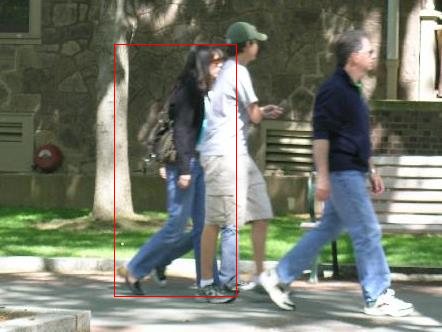

In [10]:
image